# 信号波形ビューア
このファイルは、kwaveで生成した信号波形を解析するためのものです。実機実験におけるデータも必要に応じてロード、プロットし、信号処理の違いをまとめてあります。ソースコードはすべてsrcディレクトリに保存してあり、これらをインポートし可視化のために利用します。詳細な内訳は当ディレクトリを参照してください。

In [16]:
import sys

matfile = '/mnt/matsubara/rawdata/solid_liquid_s.mat'

# Try scipy.io.loadmat
try:
    from scipy.io import loadmat
    data = loadmat(matfile)
    print("Loaded with scipy.io.loadmat (v7 or earlier).")
    print("Top-level keys:")
    for key in data:
        print(f"  {key}: {type(data[key])}, shape={getattr(data[key], 'shape', None)}")
    sys.exit(0)
except Exception as e:
    print("scipy.io.loadmat failed:", e)

# Try h5py
try:
    import h5py
    with h5py.File(matfile, 'r') as f:
        print("Loaded with h5py (v7.3 HDF5 format).")
        def print_h5_structure(g, indent=0):
            for key in g:
                item = g[key]
                if isinstance(item, h5py.Group):
                    print('  ' * indent + f"{key}/ (Group)")
                    print_h5_structure(item, indent+1)
                else:
                    print('  ' * indent + f"{key}: {item.shape}, dtype={item.dtype}")
        print_h5_structure(f)
except Exception as e:
    print("h5py failed:", e)

scipy.io.loadmat failed: Please use HDF reader for matlab v7.3 files, e.g. h5py
Loaded with h5py (v7.3 HDF5 format).
#refs#/ (Group)
  a: (2,), dtype=uint64
  b: (1, 584), dtype=uint8
  c: (1, 1), dtype=float64
  d: (1, 1), dtype=float64
  e: (1, 1), dtype=float64
  f: (1, 1), dtype=float64
  g: (1, 1), dtype=float64
  h: (1, 1), dtype=float64
  i: (1, 2008), dtype=float64
  j: (1, 748), dtype=float64
  k: (1, 108), dtype=float64
  l: (108, 748, 2008), dtype=float64
  m: (1, 1), dtype=float64
  n: (1, 1), dtype=float64
  o: (1, 1), dtype=float64
  p: (1, 1), dtype=float64
  q: (1, 1), dtype=float64
  r: (1, 1), dtype=float64
  s: (1, 1), dtype=float64
  t: (1, 2), dtype=object
  u: (2,), dtype=uint64
  v: (2,), dtype=uint64
  w: (1, 2), dtype=int32
  x: (1, 2), dtype=object
  y: (2,), dtype=uint64
  z/ (Group)
    Nt: (4, 1), dtype=uint16
    Nx: (1, 1), dtype=float64
    Ny: (1, 1), dtype=float64
    Nz: (1, 1), dtype=float64
    dim: (1, 1), dtype=float64
    dt: (4, 1), dtype=uint16

## 信号波形の概形プロット
シミュレーション生成のデータは、100μs～150μsの一パルスだけの設定です。それゆえ、実機実験の時間スケールである5秒間とは大きく状況が異なります。下のセルを実行して、信号波形の外形をプロットしてみましょう。

sensor_data shape: (300001, 101)
kgrid shape: (1, 6)
kgrid: [[3707764736          2          1          1          1          1]]


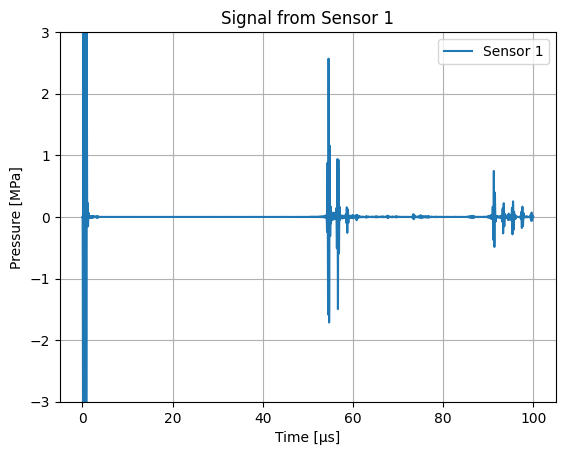

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

matfile = '/mnt/matsubara/signal_sandbox/solid_liquid2_001.mat'

with h5py.File(matfile, 'r') as f:
    # sensor_dataの取得
    sensor_data = np.array(f['sensor_data'])  # shape: (10001, 32)
    print('sensor_data shape:', sensor_data.shape)
    
    # kgridの取得（内容によってはt_arrayが含まれている場合もある）
    if 'kgrid' in f:
        kgrid = np.array(f['kgrid'])
        print('kgrid shape:', kgrid.shape)
        print('kgrid:', kgrid)
    else:
        kgrid = None

# 仮の時間軸を作成（例: 10001点, サンプリング間隔dt=1.0e-8秒と仮定）
dt = 1/sensor_data.shape[0]*1e-4
t_array = np.arange(sensor_data.shape[0]) * dt

# 1ch目の信号をプロット
plt.figure()
plt.plot(t_array * 1e6, sensor_data[:, 16] * 1e-4, label='Sensor 1')
plt.xlabel('Time [μs]')
plt.ylabel('Pressure [MPa]')
plt.ylim(-3, 3)  # y軸の範囲を-0.2から0.2に設定
plt.title('Signal from Sensor 1')
plt.grid(True)
plt.legend()
plt.show()

## 詳細な解析
上でプロットした信号波形には重要な情報が多く含まれています。これらのうち、物理的に明確に意味がある領域は50μs以降となっています。これらを、ピーク毎にわけて詳細にプロットしてみましょう。

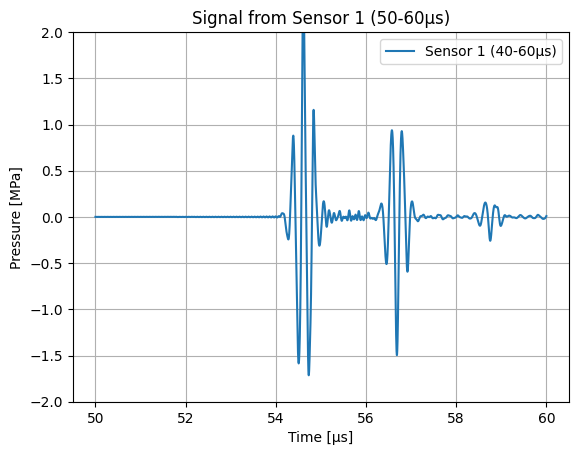

50μsから55μsの区間の最大値: 25692.661458 [Pa]（時刻: 54.610 μs）
55μsから60μsの区間の最大値: 9377.717448 [Pa]（時刻: 56.574 μs）


In [58]:

start_us = 50  # 開始時間 [μs]
end_us = 60   # 終了時間 [μs]
# インデックス範囲を計算
start_idx = np.searchsorted(t_array * 1e6, start_us)
end_idx = np.searchsorted(t_array * 1e6, end_us)
upper_limit = 2
lower_limit = -2
plt.figure()
plt.plot(t_array[start_idx:end_idx] * 1e6, sensor_data[start_idx:end_idx, 16] * 1e-4, label='Sensor 1 (40-60μs)')
plt.xlabel('Time [μs]')
plt.ylabel('Pressure [MPa]')
# タイトルの時間範囲を変数で受け取れるようにする
plt.title(f'Signal from Sensor 1 ({start_us}-{end_us}μs)')
plt.ylim(lower_limit, upper_limit)  # 詳細表示なのでy軸も狭める
plt.grid(True)
plt.legend()
plt.show()
# 50μsから55μs、55μsから60μsの区間ごとに信号の最大値とその時刻を出力する

# 50μsから55μsの区間
start_us_1 = 50
end_us_1 = 55
start_idx_1 = np.searchsorted(t_array * 1e6, start_us_1)
end_idx_1 = np.searchsorted(t_array * 1e6, end_us_1)

segment1 = sensor_data[start_idx_1:end_idx_1, 16]
max_val_1 = np.max(segment1)
max_idx_1 = np.argmax(segment1)
max_time_1 = t_array[start_idx_1 + max_idx_1] * 1e6  # [μs]

print(f"{start_us_1}μsから{end_us_1}μsの区間の最大値: {max_val_1:.6f} [Pa]（時刻: {max_time_1:.3f} μs）")

# 55μsから60μsの区間
start_us_2 = 55
end_us_2 = 60
start_idx_2 = np.searchsorted(t_array * 1e6, start_us_2)
end_idx_2 = np.searchsorted(t_array * 1e6, end_us_2)

segment2 = sensor_data[start_idx_2:end_idx_2, 16]
max_val_2 = np.max(segment2)
max_idx_2 = np.argmax(segment2)
max_time_2 = t_array[start_idx_2 + max_idx_2] * 1e6  # [μs]

print(f"{start_us_2}μsから{end_us_2}μsの区間の最大値: {max_val_2:.6f} [Pa]（時刻: {max_time_2:.3f} μs）")

## 理論的整理
生成した信号は、４MHzで照射したことを思い出そう。これらに対しフーリエ変換・ヒルベルト変換と呼ばれる処理を施すことによって重要な性質が見えてくる。

Envelope Peak (50-55μs): Value = 26126.023645 [Pa], Time = 54.600 μs
Envelope Peak (55-60μs): Value = 14958.295439 [Pa], Time = 56.685 μs


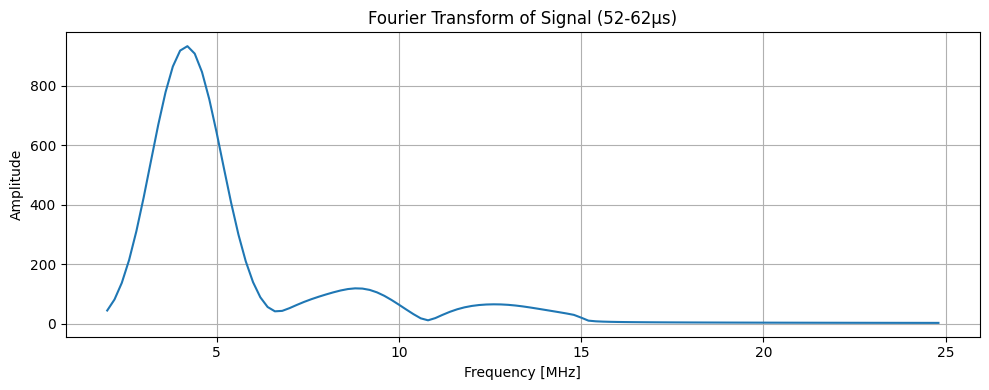

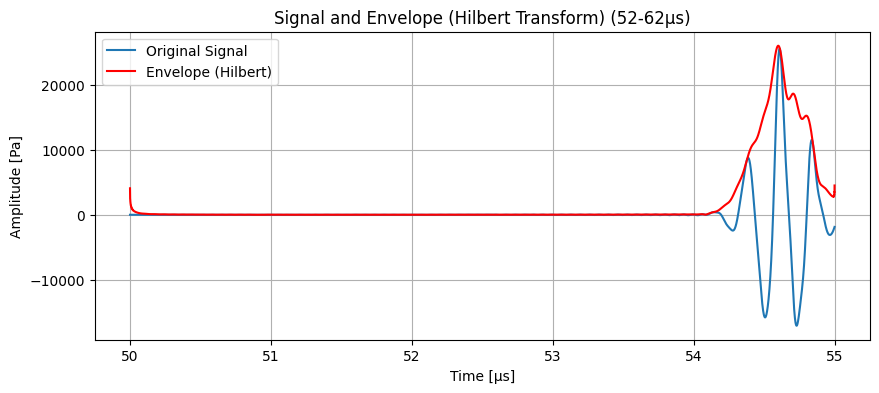

In [59]:
# 50μsから55μsの区間の信号を取り出す
segment1 = sensor_data[start_idx_1:end_idx_1, 16]
start_us = 52  # 開始時間 [μs]
end_us = 62    # 終了時間 [μs]
start_us_1 = 52
end_us_1 = 62
start_us_2 = 55
end_us_2 = 60
# フーリエ変換を行う
N = len(segment1)
dt = t_array[1] - t_array[0]  # サンプリング間隔 [s]
fs = 1.0 / dt                 # サンプリング周波数 [Hz]
freqs = np.fft.rfftfreq(N, d=dt)
fft_vals = np.fft.rfft(segment1)

# 振幅スペクトルを計算
amplitude = np.abs(fft_vals) / N

# Perform Hilbert transform and calculate envelope
from scipy.signal import hilbert, find_peaks
analytic_signal = hilbert(segment1)
envelope = np.abs(analytic_signal)

# Find the largest peak in the envelope for 50-55μs
peaks1, _ = find_peaks(envelope)
if len(peaks1) >= 1:
    # Get the index of the highest peak
    peak_amplitudes1 = envelope[peaks1]
    top_idx1 = np.argmax(peak_amplitudes1)
    peak_idx1 = peaks1[top_idx1]
    peak_time1 = t_array[start_idx_1 + peak_idx1] * 1e6  # [μs]
    peak_value1 = envelope[peak_idx1]
    print(f"Envelope Peak (50-55μs): Value = {peak_value1:.6f} [Pa], Time = {peak_time1:.3f} μs")
else:
    print("No peaks found in the envelope for 50-55μs.")

# Find the largest peak in the envelope for 55-60μs
segment2 = sensor_data[start_idx_2:end_idx_2, 16]
analytic_signal2 = hilbert(segment2)
envelope2 = np.abs(analytic_signal2)
peaks2, _ = find_peaks(envelope2)
if len(peaks2) >= 1:
    # Get the index of the highest peak
    peak_amplitudes2 = envelope2[peaks2]
    top_idx2 = np.argmax(peak_amplitudes2)
    peak_idx2 = peaks2[top_idx2]
    peak_time2 = t_array[start_idx_2 + peak_idx2] * 1e6  # [μs]
    peak_value2 = envelope2[peak_idx2]
    print(f"Envelope Peak (55-60μs): Value = {peak_value2:.6f} [Pa], Time = {peak_time2:.3f} μs")
else:
    print("No peaks found in the envelope for 55-60μs.")

# Plot Fourier transform result (only 4MHz±2MHz range)
plt.figure(figsize=(10,4))
freqs_mhz = freqs * 1e-6
# Extract and display only the range 4MHz±2MHz
mask = (freqs_mhz >= 2.0) & (freqs_mhz <= 25.0)
plt.plot(freqs_mhz[mask], amplitude[mask])
plt.xlabel('Frequency [MHz]')
plt.ylabel('Amplitude')
plt.title(f'Fourier Transform of Signal ({start_us}-{end_us}μs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot Hilbert transform (envelope) result
plt.figure(figsize=(10,4))
plt.plot(t_array[start_idx_1:end_idx_1]*1e6, segment1, label='Original Signal')
plt.plot(t_array[start_idx_1:end_idx_1]*1e6, envelope, label='Envelope (Hilbert)', color='red')
plt.xlabel('Time [μs]')
plt.ylabel('Amplitude [Pa]')
plt.title(f'Signal and Envelope (Hilbert Transform) ({start_us}-{end_us}μs)')
plt.legend()
plt.grid(True)
plt.show()


Available keys in file:
- Tstart: shape=(1, 1)
- Tinterval: shape=(1, 1)
- ExtraSamples: shape=(1, 1)
- RequestedLength: shape=(1, 1)
- Length: shape=(1, 1)
- Version: shape=(1,)
- TDX1: shape=(1, 260416673)
- TDX2: shape=(1, 260416673)
- TDX3: shape=(1, 260416673)
- TDX1_enlarged: shape=(1, 260416673)
Using channel: TDX1
Sampling rate from file: 52.1 MHz


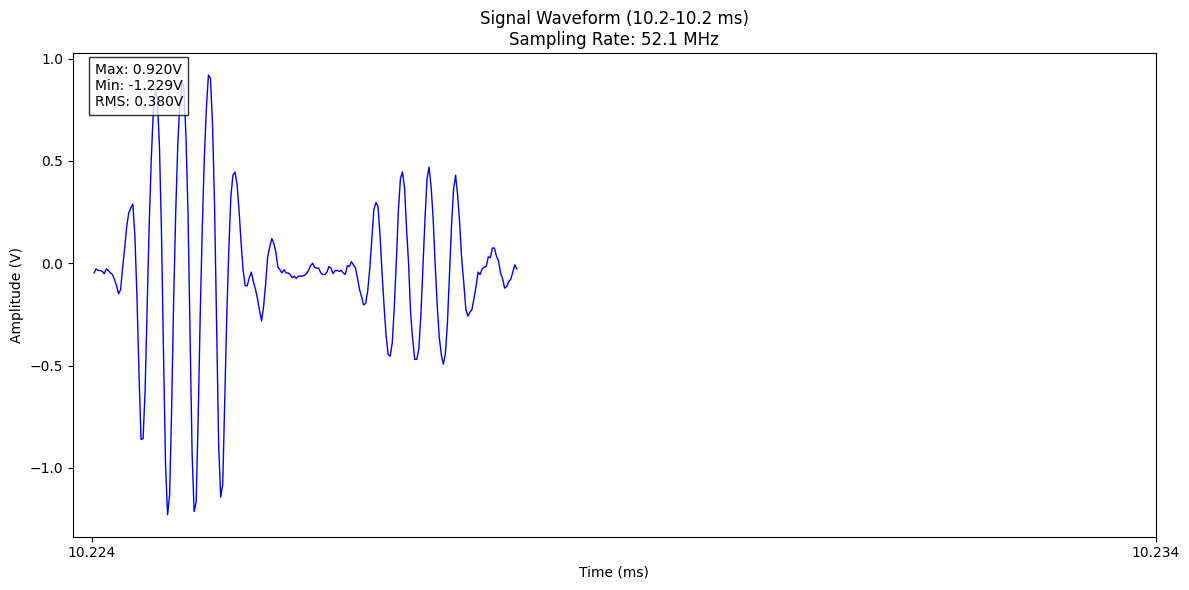

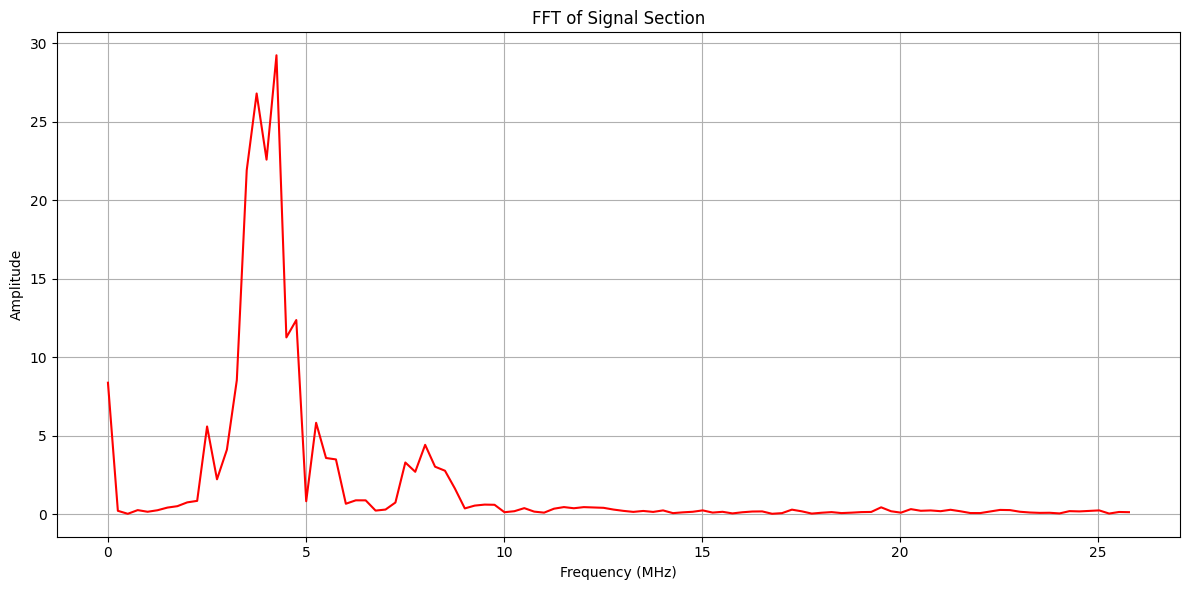

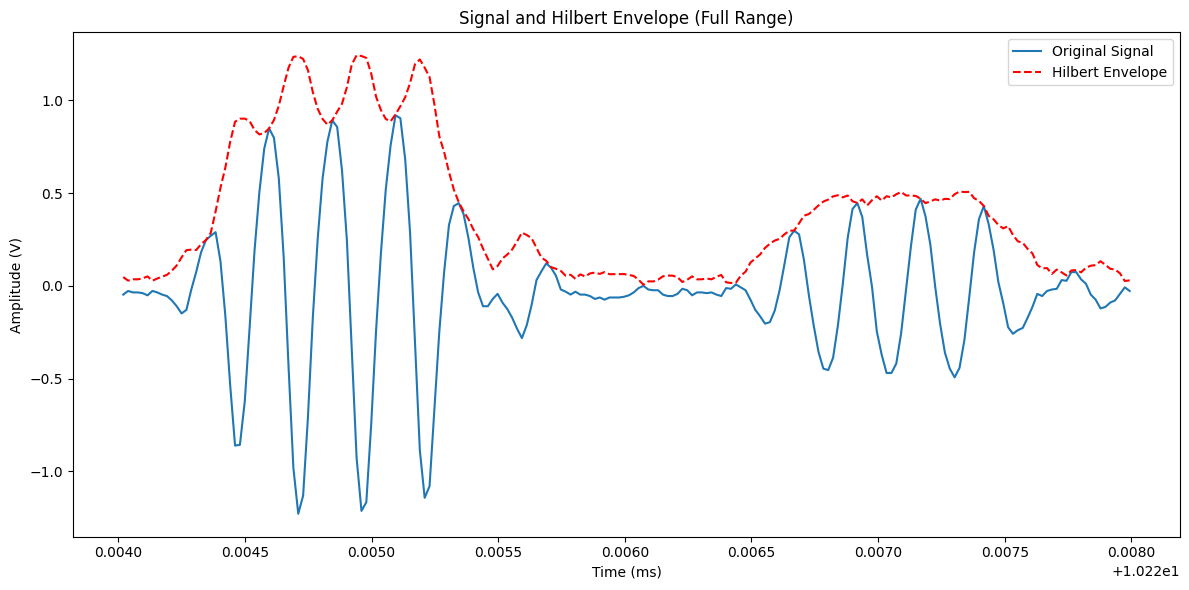

Envelope max value: 1.243606 V
Time at envelope max: 10.224941 ms


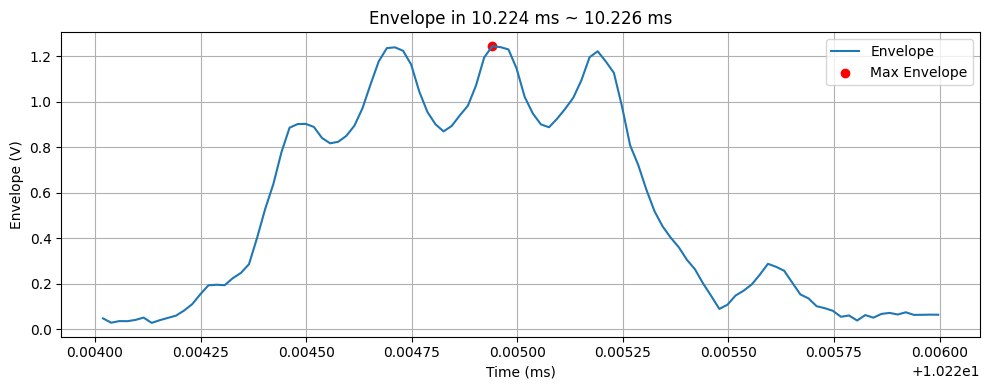

In [14]:

import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
def plot_signal_waveform(file_path, start_ms=0, end_ms=100):
    """
    Display signal waveform from .mat file

    Parameters:
    -----------
    file_path : str
        Path to .mat file
    start_ms : float 
        Start time (milliseconds)
    end_ms : float
        End time (milliseconds)
    """
    # Load and inspect data
    mat_data = sio.loadmat(file_path)

    # Display available keys
    print("Available keys in file:")
    for key in mat_data.keys():
        if not key.startswith('__'):
            print(f"- {key}: shape={mat_data[key].shape}")

    # Try different possible channel names
    channel_names = ['TDX1', 'A', 'B', 'Channel_A', 'Channel_1']
    signal = None

    for name in channel_names:
        if name in mat_data:
            signal = mat_data[name].flatten()
            print(f"Using channel: {name}")
            break

    if signal is None:
        raise ValueError("No valid channel found in the file")

    # Get sampling frequency
    if 'Tinterval' in mat_data:
        sampling_interval = mat_data['Tinterval'][0][0]  # sampling interval (s)
        sampling_rate = 1 / sampling_interval
        print(f"Sampling rate from file: {sampling_rate/1e6:.1f} MHz")
    else:
        print("Warning: Sampling rate not found, using default 62.5MHz")
        sampling_rate = 62.5e6  # Hz

    # Generate time axis (milliseconds)
    time_ms = np.arange(len(signal)) / sampling_rate * 1000

    # Limit display range
    mask = (time_ms >= start_ms) & (time_ms <= end_ms)

    # Create plot
    plt.figure(figsize=(12, 6))
    plt.plot(time_ms[mask], signal[mask], 'b-', linewidth=1)
    # plt.grid(True, which='both')
    # plt.minorticks_on()
    plt.xlabel('Time (ms)')
    plt.ylabel('Amplitude (V)')
    plt.title(f'Signal Waveform ({start_ms:.1f}-{end_ms:.1f} ms)\nSampling Rate: {sampling_rate/1e6:.1f} MHz')

    # Set x-axis ticks
    tick_interval = 0.01  # 0.01ms intervals
    plt.xticks(np.arange(start_ms, end_ms + tick_interval, tick_interval))

    # Display statistics
    signal_section = signal[mask]
    plt.text(
        0.02, 0.98,
        f'Max: {np.max(signal_section):.3f}V\n'
        f'Min: {np.min(signal_section):.3f}V\n'
        f'RMS: {np.sqrt(np.mean(signal_section**2)):.3f}V',
        transform=plt.gca().transAxes,
        bbox=dict(facecolor='white', alpha=0.8),
        verticalalignment='top'
    )

    plt.tight_layout()
    plt.show()

    # FFTとヒルベルト変換の表示
    if signal_section.ndim == 1 and signal_section.size > 0:
        # FFT
        fft_signal = np.fft.fft(signal_section)
        fft_freq = np.fft.fftfreq(len(signal_section), d=1/sampling_rate) / 1e6  # MHz

        plt.figure(figsize=(12, 6))
        plt.plot(fft_freq[:len(fft_freq)//2], np.abs(fft_signal)[:len(fft_signal)//2], 'r-')
        plt.xlabel('Frequency (MHz)')
        plt.ylabel('Amplitude')
        plt.title('FFT of Signal Section')
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("Warning: signal_section is empty or not 1D. FFT is skipped.")

    # Hilbert transform (calculate once for the whole signal_section)
    try:
        from scipy.signal import hilbert
        analytic_signal = hilbert(signal_section)
        envelope = np.abs(analytic_signal)

        # 表示区間の時間軸（time_ms[mask]）はsignal_sectionやenvelopeと同じ長さ
        time_section = time_ms[mask]

        # 元信号とヒルベルト包絡線を全区間で表示
        plt.figure(figsize=(12, 6))
        plt.plot(time_section, signal_section, label='Original Signal')
        plt.plot(time_section, envelope, 'r--', label='Hilbert Envelope')
        plt.xlabel('Time (ms)')
        plt.ylabel('Amplitude (V)')
        plt.title('Signal and Hilbert Envelope (Full Range)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Set the interval manually
        start_ms_custom = 10.224
        end_ms_custom = 10.226

        # Create a mask for the specified interval
        mask_custom = (time_ms >= start_ms_custom) & (time_ms <= end_ms_custom)
        signal_section_custom = signal[mask_custom]

        # Calculate the envelope using Hilbert transform
        # Do not recalculate the Hilbert transform here. Instead, extract the corresponding interval from the already calculated envelope.
        # However, since the length of envelope is not the same as the original signal, 
        # we need to find the indices in time_section (the time axis for the envelope) that correspond to start_ms_custom and end_ms_custom.
        # Use np.searchsorted to find the start and end indices.
        start_idx = np.searchsorted(time_section, start_ms_custom, side='left')
        end_idx = np.searchsorted(time_section, end_ms_custom, side='right')
        envelope_custom = envelope[start_idx:end_idx]

        # Time axis for the interval
        time_section_custom = time_ms[mask_custom]

        # Calculate the maximum value of the envelope and its corresponding time
        max_env = np.max(envelope_custom)
        max_idx = np.argmax(envelope_custom)
        max_time = time_section_custom[max_idx]

        # Output the results
        print(f"Envelope max value: {max_env:.6f} V")
        print(f"Time at envelope max: {max_time:.6f} ms")

        # Plot the envelope in the specified interval
        plt.figure(figsize=(10, 4))
        plt.plot(time_section_custom, envelope_custom, label='Envelope')
        plt.scatter([max_time], [max_env], color='red', label='Max Envelope')
        plt.xlabel('Time (ms)')
        plt.ylabel('Envelope (V)')
        plt.title(f'Envelope in {start_ms_custom} ms ~ {end_ms_custom} ms')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Hilbert transform failed: {e}")

            
# Run analysis
#file_path = '/mnt/sdb/matsubara/tmp/sensor_data.mat'
file_path = "/mnt/yamaguchi/P20240726-1600.mat"
plot_signal_waveform(file_path, start_ms=10.224, end_ms=10.228)